In [45]:
# Importing modules
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import f1_score

data = pd.read_csv('movies_filled_cleaned_processed.csv')
# Print head
data.head()

,Title,Movie Info,Distributor,Release Date,Domestic Sales (in $),International Sales (in $),World Sales (in $),Genre,Movie Runtime,License,release_date_filled,release_year,running_time_mins
0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a de...",Walt Disney Studios Motion Pictures,"December 16, 2015",936662225,1132859475,2069521700,"['Action', 'Adventure', 'Sci-Fi']",2 hr 18 min,PG-13,"December 16, 2015",2015,138
1,Avengers: Endgame (2019),After the devastating events of Avengers: Infi...,Walt Disney Studios Motion Pictures,"April 24, 2019",858373000,1939128328,2797501328,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",3 hr 1 min,PG-13,"April 24, 2019",2019,181
2,Avatar (2009),A paraplegic Marine dispatched to the moon Pan...,Twentieth Century Fox,"December 16, 2009",760507625,2086738578,2847246203,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",2 hr 42 min,PG-13,"December 16, 2009",2009,162
3,Black Panther (2018),"T'Challa, heir to the hidden but advanced king...",Walt Disney Studios Motion Pictures,NaN,700426566,647171407,1347597973,"['Action', 'Adventure', 'Sci-Fi']",2 hr 14 min,NaN,"January 29, 2018",2018,134
4,Avengers: Infinity War (2018),The Avengers and their allies must be willing ...,Walt Disney Studios Motion Pictures,NaN,678815482,1369544272,2048359754,"['Action', 'Adventure', 'Sci-Fi']",2 hr 29 min,NaN,"April 23, 2018",2018,149


In [64]:
data_g = data[['Genre', 'Movie Info']]

In [120]:
for i, col in enumerate(data_g.columns):
    data_g.iloc[:, i] = data_g.iloc[:, i].str.replace("'", "")
    data_g.iloc[:, i] = data_g.iloc[:, i].str.replace("[", "")
    data_g.iloc[:, i] = data_g.iloc[:, i].str.replace("]", "")
    
data_g['Genre'] = data_g['Genre'].str.split(',')

<ipython-input-120-4aa9644945d3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data_g.iloc[:, i] = data_g.iloc[:, i].str.replace("[", "")
<ipython-input-120-4aa9644945d3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data_g.iloc[:, i] = data_g.iloc[:, i].str.replace("]", "")


In [121]:
data = data_g

In [122]:
data['Genre'][0]

['Action', ' Adventure', ' Sci-Fi']

In [123]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [124]:
data['Movie Info Clean'] = data['Movie Info'].apply(lambda x: clean_text(x))

In [125]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  



In [126]:


# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['Movie Info Clean'] = data['Movie Info Clean'].apply(lambda x: remove_stopwords(x))

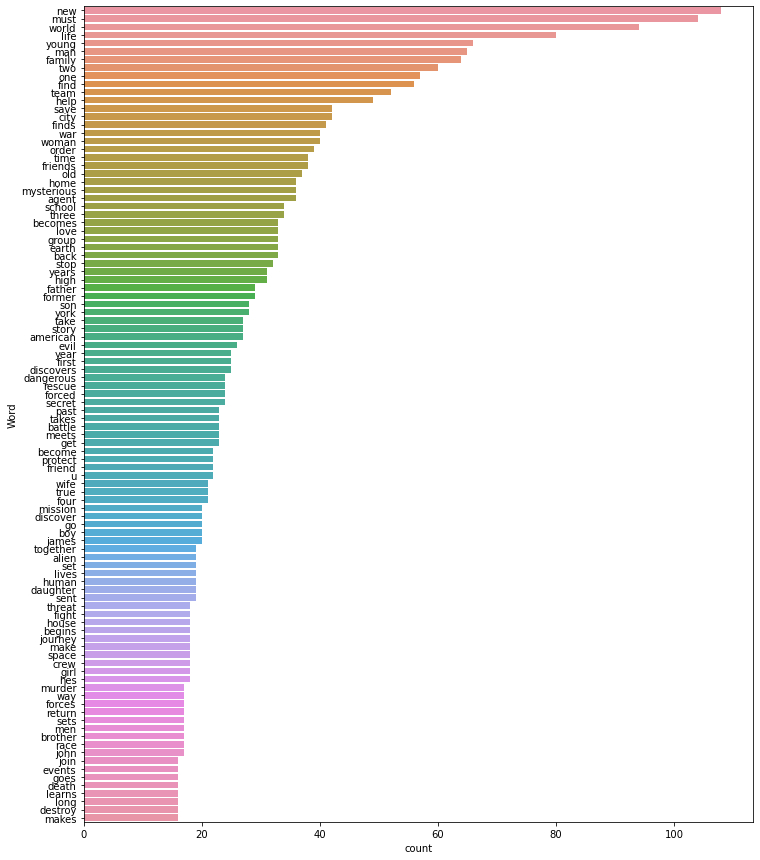

In [127]:
freq_words(data['Movie Info Clean'], 100)

In [128]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data['Genre'])

# transform target variable
y = multilabel_binarizer.transform(data['Genre'])

In [129]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [130]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(data['Movie Info Clean'], y, test_size=0.2, random_state=9)

In [131]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [132]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [156]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/Users/aruvi/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:80: UserWarning: Label not 5 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=LogisticRegression())

In [172]:
t = 0.3 # threshold value
y_pred_prob = clf.predict_proba(xval_tfidf)
y_pred = (y_pred_prob >= t).astype(int)

In [173]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.44357976653696496

In [174]:
multilabel_binarizer.inverse_transform(y_pred)[30]

('Action',)